In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Wanaka 2020 energy calibration files
"_excluded1836keV" means that the calibrations on each strip were generated having manually excluded the 1836 keV peak from the calibraiton in melinator. File names without this description contain calibrations with the peak included. 

Note: the poly3 excluding 1836 keV, poly1, and poly1 excluding 1836 keV .ecal files only contain detectors 0-5. The .ecal file for poly3 is the only one with all detectors.

In [2]:
ecal_poly3 = "ecal_Wanaka2020_201005.ecal" # all detectors
ecal_poly3_excluded1836keV = "ecal_Wanaka2020_dets0-5_poly3_excluded1836keV.ecal"

ecal_poly1 = "ecal_Wanaka2020_dets0-5_poly1.ecal"
ecal_poly1_excluded1836keV = "ecal_Wanaka2020_dets0-5_poly1_excluded1836keV.ecal"

## Find strips that did/did not identify Y-88 1.836 MeV

In [45]:
# Find and plot which strips fail to identify the 1.836 MeV Y-88 peak
def identifyY88(file,plot=True):
    f = open(file,"r")
    lines = f.readlines()

    strip_ct = 0; no1_8MeV = 0; yes1_8MeV = 0

    strip_det_grid_n = np.zeros((37,12))
    strip_det_grid_p = np.zeros((37,12))
    
    noY88 = []; stripY88 = []; ADCY88 = []

    for line in lines:
        line = line.split(" ")
        if line[0] == "CP":
            strip_ct += 1
            det = int(line[2]); strip = int(line[3]); side = line[4]

            if "1836.06" not in line:
                no1_8MeV += 1
                if side == "n":
                    strip_det_grid_n[strip-1][det] = 1
                if side == "p":
                    strip_det_grid_p[strip-1][det] = 1  
                noY88.append(str(det)+" "+str(strip)+" "+side)
            else:
                yes1_8MeV += 1
                stripY88.append(str(det)+" "+str(strip)+" "+side)
                ADCY88.append(float(line[line.index("1836.06")-1]))
    #print("% of strips that don't identify Y-88 1.8MeV: ",100.*no1_8MeV/strip_ct)
    if plot == True:
        x,y = np.meshgrid(np.arange(12),np.arange(37))
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

        # n side
        plt.rc('axes', axisbelow=True); plt.grid()
        ax1.scatter(x,y,s=strip_det_grid_n,c='k',label="No 1.8MeV identified")
        ax1.set_title("DC strips")
        ax1.set_ylabel("Strip number"); ax1.set_xlabel("Detector number")

        # p side
        plt.rc('axes', axisbelow=True); plt.grid()
        ax2.scatter(x,y,s=strip_det_grid_p,c='k',label="No 1.8MeV identified")
        ax2.set_title("AC strips")
        ax2.set_ylabel("Strip number"); ax2.set_xlabel("Detector number")
        ax2.legend(bbox_to_anchor=[1.3,0.5], loc="center")
        
    f.close()
    return [noY88,stripY88,ADCY88]

In [46]:
# Get list of strips that don't identify Y-88 for Hadar
# noY88 = identifyY88(ecal_poly3,plot=False)[0];
# with open("noY88_1836keV_ecal_Wanaka2020_201005.txt","w") as f:
#     print(noY88,file=f)
# f.close()

Wanaka 2020 poly3: 


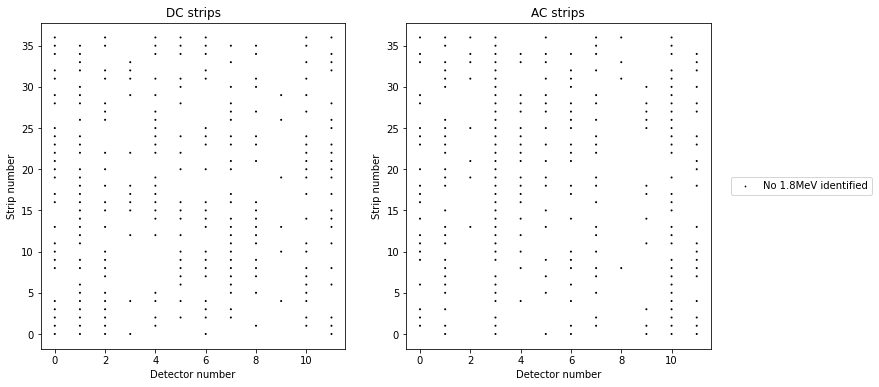

In [47]:
print("Wanaka 2020 poly3: ");identifyY88(ecal_poly3);
#print("Wanaka 2016 poly3: ");identifyY88("EnergyCalibration.ecal");

Evidently, many strips do not identify the 1.836 MeV peak. This notebook serves to examine why the strips are not identified and the impact of the 1.836 MeV peak, or lack thereof, on the calibration model's ability to extrapolate to high energies. 

## Why do the strips fail to identify 1.836 MeV?
### An investigation of CC gains. Using poly3 and poly1 calibration files.

In [6]:
def d_energyADC(file):
    file_object = open(str(file),"r")
    lines = file_object.readlines()
    d = {}
    
    for line in lines:
        if line.startswith("CP"):
            if int(line.split()[6]) > 0:
                det = line.split()[2]; strip = line.split()[3]; side = line.split()[4] 
                key = det+" "+strip+" "+side
                ADC = np.array([float(i) for i in line.split()[7::3]])
                energy = np.array([float(i) for i in line.split()[8::3]])
                FWHM = np.array([float(i) for i in line.split()[9::3]])
                d[key] = [ADC,energy,FWHM]
    return d

In [7]:
def d_model(file):
    file_object = open(str(file),"r")
    lines = file_object.readlines()
    model = []; d = {}
    
    for line in lines:
        if line.startswith("CP"):
            det = line.split()[2]; strip = line.split()[3]; side = line.split()[4] 
            key = det+" "+strip+" "+side
        
        if line.startswith("CM"):
            if key in line:
                model = [float(x) for x in line.split()[6:]]
                max_num_coeffs = 5
                if len(model) < max_num_coeffs:
                    model.extend([0]*(max_num_coeffs - len(model)))

                if len(model) > max_num_coeffs:
                    print("You're using a calibration model with more than 5 coefficients. Code isn't updated for that yet. Sorry.")

                d[key] = model
    return d

In [8]:
def energy_to_ADC(energy,coeffs): # from the GSE's energycal.py
    roots = np.roots([coeffs[3],coeffs[2],coeffs[1],coeffs[0]-energy])
    adc = 0
    for root in roots:
        ## comment out below if statement bc I want to see the >8191 ADC for these tests
        #if root > 0 and root < 8192:
        adc = root 
    return np.real(adc)

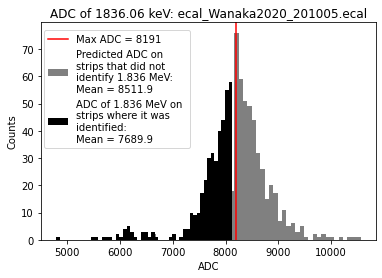

In [51]:
# Get the calibration coefficients for all strips in this .ecal
model_coeffs_poly3 = d_model(ecal_poly3)

# List of strips that don't identify 1.836 MeV
noY88_poly3 = identifyY88(ecal_poly3,plot=False)[0];

# For the strips that don't identify 1.836 MeV, predict the ADC value at which it would have appeared
#  based on the calibration model.
predicted_ADC_poly3 = []
for key in model_coeffs_poly3.keys():
    if key in noY88_poly3:
        model_coeffs = model_coeffs_poly3[key]
        predicted_ADC = np.real(energy_to_ADC(1836,model_coeffs))
        predicted_ADC_poly3.append(predicted_ADC)

plt.hist(predicted_ADC_poly3,bins=50,label=f"Predicted ADC on \nstrips that did not \nidentify 1.836 MeV: \nMean = {round(np.mean(predicted_ADC_poly3),1)}",color="gray");


# List of strips that did identify 1.836 MeV
ADCY88_poly3 = np.real(identifyY88(ecal_poly3,plot=False)[2]);
plt.hist(ADCY88_poly3,bins=50,label=f"ADC of 1.836 MeV on \nstrips where it was \nidentified: \nMean = {round(np.mean(ADCY88_poly3),1)}",color='k');

plt.title("ADC of 1836.06 keV: {}".format(ecal_poly3))
#plt.text(x=4600,y=70,s="Mean predicted ADC = {}".format(round(np.mean(predicted_ADC_poly3),1)))
#plt.text(x=4600,y=65,s="Mean identified ADC = {}".format(round(np.mean(ADCY88_poly3),1)))
plt.xlabel("ADC");plt.ylabel("Counts")
plt.axvline(x=8191,c='r',label="Max ADC = 8191")
plt.legend(bbox_to_anchor=(.46,0.4));


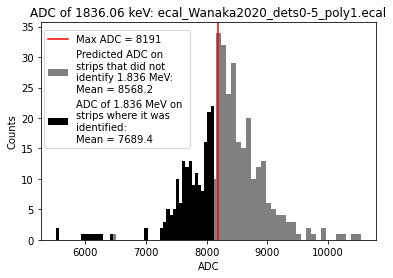

In [50]:
# Get the calibration coefficients for all strips in this .ecal
model_coeffs_poly1 = d_model(ecal_poly1)

# List of strips that don't identify 1.836 MeV
noY88_poly1 = identifyY88(ecal_poly1,plot=False)[0];

# For the strips that don't identify 1.836 MeV, predict the ADC value at which it would have appeared
#  based on the calibration model.
predicted_ADC_poly1 = []
for key in model_coeffs_poly1.keys():
    if key in noY88_poly1:
        model_coeffs = model_coeffs_poly1[key]
        predicted_ADC = energy_to_ADC(1836,model_coeffs)
        predicted_ADC_poly1.append(predicted_ADC)
        
#plt.hist(predicted_ADC_poly1,bins=50,label="Predicted ADC on strips that did not identify 1.836 MeV",color="skyblue");
plt.hist(predicted_ADC_poly1,bins=50,label=f"Predicted ADC on \nstrips that did not \nidentify 1.836 MeV: \nMean = {round(np.mean(predicted_ADC_poly1),1)}",color="gray");


# List of strips that did identify 1.836 MeV
ADCY88_poly1 = identifyY88(ecal_poly1,plot=False)[2];
#plt.hist(ADCY88_poly1,bins=50,label="ADC of 1.836 MeV on strips where it was identified");
plt.hist(ADCY88_poly1,bins=50,label=f"ADC of 1.836 MeV on \nstrips where it was \nidentified: \nMean = {round(np.mean(ADCY88_poly1),1)}",color='k');


plt.title("ADC of 1836.06 keV: {}".format(ecal_poly1))
#plt.text(x=5500,y=32,s="Mean predicted ADC = {}".format(round(np.mean(predicted_ADC_poly1),1)))
#plt.text(x=5500,y=30,s="Mean identified ADC = {}".format(round(np.mean(ADCY88_poly1),1)))
plt.xlabel("ADC");plt.ylabel("Counts")
plt.axvline(x=8191,c='r',label="Max ADC = 8191")
plt.legend(bbox_to_anchor=(.46,0.4));


True of both the poly3 and poly1 calibrations:

It appears that the gains on the strips that fail to identify 1.836 MeV are set too high. The large majority of ADC values at which the peak would have appeared, as calculated by the energy calibration's model, lie above our maximum ADC value of 8191. As a cross-check of this conclusion, the ADC values of the 1.836 MeV peak on strips where it was identified all lie below the maximum ADC value of 8191.

## Compare poly1 performance at 1.6 MeV
### 1.836 MeV included vs. excluded only on strips that identified 1.836 MeV

In [11]:
def adc_diff(ecal1,ecal2,strips,energy_of_interest):
    ADC_diff = []; predictADC_1_ls = []; predictADC_2_ls = []
    strips1 = [x for x in d_energyADC(ecal1).keys()]
    strips2 = [x for x in d_energyADC(ecal2).keys()]
    
    for key in strips:
        if key in list(set(strips1) & set(strips2)):
            d_model_1 = d_model(ecal1); d_model_2 = d_model(ecal2)

            predictADC_1 = energy_to_ADC(energy_of_interest,d_model_1[key])
            predictADC_2 = energy_to_ADC(energy_of_interest,d_model_2[key])
            predictADC_1_ls.append(predictADC_1); predictADC_2_ls.append(predictADC_2)

            predictADC_diff = predictADC_1 - predictADC_2
            ADC_diff.append(predictADC_diff)
    
    return ADC_diff,predictADC_1_ls,predictADC_2_ls

In [12]:
energy_of_interest = 1600. # keV

Mean difference = -1.08 ADC


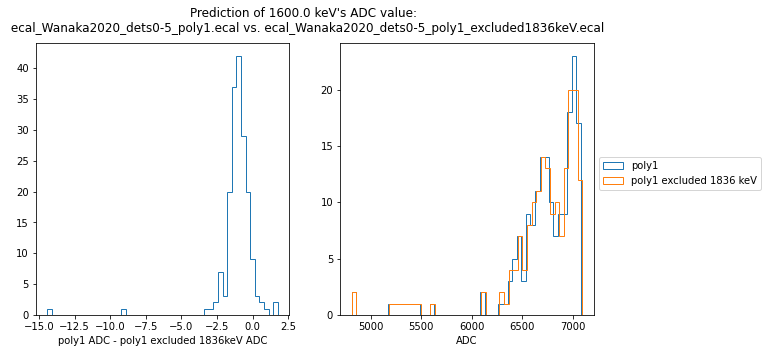

In [13]:
stripsY88_poly1 = identifyY88(ecal_poly1,plot=False)[1];
poly1_1600_diff,poly1_1600,poly1_excluded1836keV_1600 = adc_diff(ecal_poly1,ecal_poly1_excluded1836keV,stripsY88_poly1,energy_of_interest);
print("Mean difference = {} ADC".format(round(np.mean(poly1_1600_diff),2)))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
f.suptitle("Prediction of {} keV's ADC value: \n {} vs. {}".format(energy_of_interest,ecal_poly1,ecal_poly1_excluded1836keV))

ax1.hist(poly1_1600_diff,bins=50,histtype='step')
ax1.set_xlabel("poly1 ADC - poly1 excluded 1836keV ADC")

ax2.hist(poly1_1600,bins=50,histtype="step",label="poly1");
ax2.hist(poly1_excluded1836keV_1600,bins=50,histtype="step",label="poly1 excluded 1836 keV");
ax2.legend(bbox_to_anchor=(1.,0.6));ax2.set_xlabel("ADC");

For the poly1 calibration, the predictions of the ADC value at 1.6 MeV do not differ significantly when including/excluding the 1.836 MeV peak. Mean ADC including - excluding = -1.08 ADC

## Compare poly3 performance at 1.6 MeV
### 1.836 MeV included vs. excluded only on strips that identified 1.836 MeV

Mean difference = -4.65 ADC


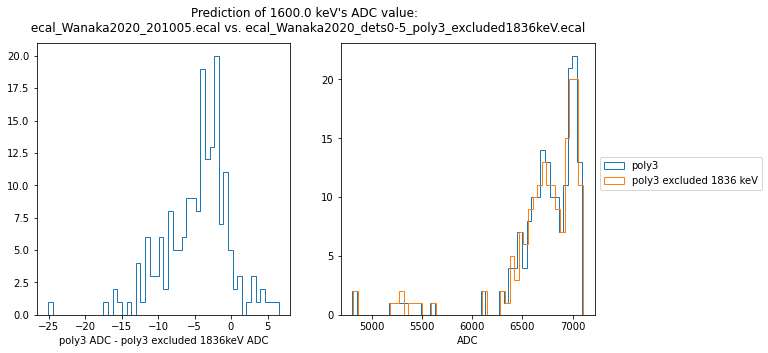

In [14]:
stripsY88_poly3 = identifyY88(ecal_poly3,plot=False)[1];
poly3_1600_diff,poly3_1600,poly3_excluded1836keV_1600 = adc_diff(ecal_poly3,ecal_poly3_excluded1836keV,stripsY88_poly3,energy_of_interest);
print("Mean difference = {} ADC".format(round(np.mean(poly3_1600_diff),2)))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
f.suptitle("Prediction of {} keV's ADC value: \n {} vs. {}".format(energy_of_interest,ecal_poly3,ecal_poly3_excluded1836keV))

ax1.hist(poly3_1600_diff,bins=50,histtype='step')
ax1.set_xlabel("poly3 ADC - poly3 excluded 1836keV ADC")

ax2.hist(poly3_1600,bins=50,histtype="step",label="poly3");
ax2.hist(poly3_excluded1836keV_1600,bins=50,histtype="step",label="poly3 excluded 1836 keV");
ax2.legend(bbox_to_anchor=(1.,0.6));ax2.set_xlabel("ADC");

For a poly3 calibration, the predictions of the ADC value at 1.6 MeV differ more than those of the poly1 calibration when including/excluding the 1.836 MeV peak. Here, the mean ADC including - excluding = -4.65 ADC

## Compare poly3 vs. poly1 performance at 1.6 MeV
### All strips, 1.836 MeV included

In [15]:
allstrips_poly1 = [x for x in d_energyADC(ecal_poly1).keys()]
allstrips_poly3 = [x for x in d_energyADC(ecal_poly3).keys()]
strips_poly3and1 = list(set(allstrips_poly1) & set(allstrips_poly3))

Mean difference = -1.35 ADC


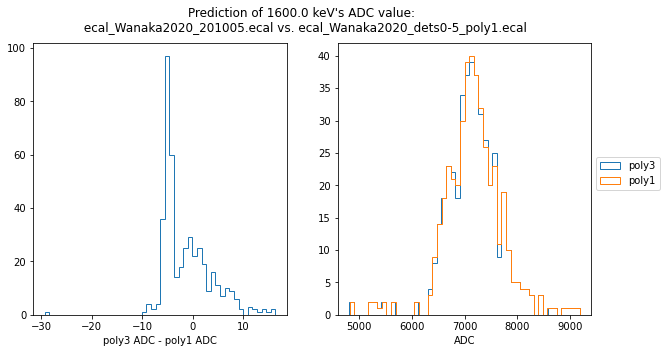

In [16]:
allpoly3and1_1600_diff,allpoly3_1600,allpoly1_1600 = adc_diff(ecal_poly3,ecal_poly1,strips_poly3and1,energy_of_interest);
print("Mean difference = {} ADC".format(round(np.mean(allpoly3and1_1600_diff),2)))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
f.suptitle("Prediction of {} keV's ADC value: \n {} vs. {}".format(energy_of_interest,ecal_poly3,ecal_poly1))

ax1.hist(allpoly3and1_1600_diff,bins=50,histtype='step')
ax1.set_xlabel("poly3 ADC - poly1 ADC")

ax2.hist(allpoly3_1600,bins=50,histtype="step",label="poly3");
ax2.hist(allpoly1_1600,bins=50,histtype="step",label="poly1");
ax2.legend(bbox_to_anchor=(1.,0.6));ax2.set_xlabel("ADC");

As a different test, I compared the poly3 vs. poly1 ADC predictions at 1.6 MeV on all strips (rather than only on the strips that identified 1.836 MeV, as in the two tests above). They don't differ significantly; the mean ADC poly3 - poly1 = -1.35 ADC

## Compare poly3 vs. poly1 performance at 1.836 MeV
### All strips, 1.836 MeV included

Mean difference = 6.83 ADC


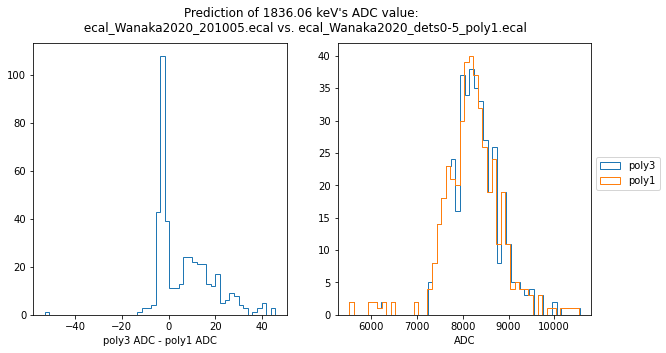

In [17]:
energy_of_interest = 1836.06 # keV
allpoly3and1_1836_diff,allpoly3_1836,allpoly1_1836 = adc_diff(ecal_poly3,ecal_poly1,strips_poly3and1,energy_of_interest);
print("Mean difference = {} ADC".format(round(np.mean(allpoly3and1_1836_diff),2)))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
f.suptitle("Prediction of {} keV's ADC value: \n {} vs. {}".format(energy_of_interest,ecal_poly3,ecal_poly1))

ax1.hist(allpoly3and1_1836_diff,bins=50,histtype='step')
ax1.set_xlabel("poly3 ADC - poly1 ADC")

ax2.hist(allpoly3_1836,bins=50,histtype="step",label="poly3");
ax2.hist(allpoly1_1836,bins=50,histtype="step",label="poly1");
ax2.legend(bbox_to_anchor=(1.,0.6));ax2.set_xlabel("ADC");

Similar to the above, here I compare the poly3 vs. poly1 ADC predictions at 1.836 MeV instead of at 1.6 MeV. They differ more significantly than the predictions at 1.6 MeV; the mean ADC poly3 - ADC poly1 = 6.83 ADC

## R^2 of poly3 vs. poly1 models
### Note that this does not address potential overfitting. 

In [933]:
def ADC_to_energy(x,model):
    energy = [model[0] + model[1]*i + model[2]*i**2 + model[3]*i**3 + model[4]*i**4 for i in x]
    return energy

In [934]:
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

In [935]:
def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

In [936]:
def R2(ecal1,ecal2):
    file_dict_1 = d_energyADC(ecal1)
    file_dict_2 = d_energyADC(ecal2)
    
    strips1 = [x for x in file_dict_1.keys()]
    strips2 = [x for x in file_dict_2.keys()]
    if strips1 == strips2:
        strips = strips1
    else:
        print("Your two .ecal files contain different strips! Using only strips that appear in both.")
        strips = list(set(strips1) & set(strips2))
        
    d_model_1 = d_model(ecal1); d_model_2 = d_model(ecal2)
    
    r2_1 = []; r2_2 = []
    for key in strips:
        ADC_1 = file_dict_1[key][0]
        energy_1 = file_dict_1[key][1]

        ADC_2 = file_dict_2[key][0]
        energy_2 = file_dict_2[key][1]

        modelE_1 = ADC_to_energy(ADC_1,d_model_1[key])
        modelE_2 = ADC_to_energy(ADC_2,d_model_2[key])

        r2_1.append(coefficient_of_determination(energy_1,modelE_1))
        r2_2.append(coefficient_of_determination(energy_2,modelE_2))

    return r2_1,r2_2

In [937]:
r2_1,r2_2 = R2(ecal_poly1,ecal_poly3)

Your two .ecal files contain different strips! Using only strips that appear in both.


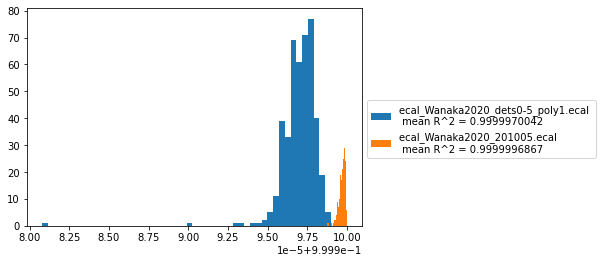

In [938]:
plt.hist(r2_1,bins=50,label="{} \n mean R^2 = {}".format(ecal_poly1,round(np.mean(r2_1),10)))
plt.hist(r2_2,bins=50,label="{} \n mean R^2 = {}".format(ecal_poly3,round(np.mean(r2_2),10)))
plt.legend(bbox_to_anchor=(1.,0.6));

R^2 doesn't tell us much of anything. Both models fit the data well, but the question here is whether or not we're fitting the data *too* well. Need a different statistical test.

## AIC, BIC comparisons of calibration models
### Try to gauge potential overfitting of higher-order polynomial models. Disclaimer: I'm not 100% sure these calculations of AIC and BIC are correct.

In [939]:
# https://www.originlab.com/doc/Origin-Help/PostFit-CompareFitFunc
def AIC(energy,model_energy,k):
    n = len(energy)
    residual = [x - y for x, y in zip(energy, model_energy)]
    RSS = np.sum([res**2 for res in residual])
    
    if n/k >= 40:
        AIC = n*np.log(RSS/n) + 2*k
    else:
        AIC = n*np.log(RSS/n) + 2*k + 2*k*(k+1)/(n-k-1)
    return AIC

In [940]:
# https://www.originlab.com/doc/Origin-Help/PostFit-CompareFitFunc
def BIC(energy,model_energy,k):
    n = len(energy)
    residual = [x - y for x, y in zip(energy, model_energy)]
    RSS = np.sum([res**2 for res in residual])

    BIC = n*np.log(RSS/n) + k*np.log(n)
    return BIC

In [941]:
def allstrips_IC(file,num_params,criterion=None):
    criterion_list = []
    file_dict = d_energyADC(file)
    strips = [x for x in file_dict.keys()]
    
    for key in strips:
        energies = file_dict[key][1]
        
        ADCs = file_dict[key][0]
        model_coeffs = d_model(file)[key]
        model_energies = ADC_to_energy(ADCs,model_coeffs)
        
        if criterion == "AIC":
            criterion_val = AIC(energies,model_energies,k=num_params)
        
        if criterion == "BIC":
            criterion_val = BIC(energies,model_energies,k=num_params)
        
        criterion_list.append(criterion_val)
    return strips,criterion_list

In [942]:
strips_poly1, AIC_poly1 = allstrips_IC(ecal_poly1,2,criterion="AIC")
strips_poly3, AIC_poly3 = allstrips_IC(ecal_poly3,4,criterion="AIC")
strips_poly1, BIC_poly1 = allstrips_IC(ecal_poly1,2,criterion="BIC")
strips_poly3, BIC_poly3 = allstrips_IC(ecal_poly3,4,criterion="BIC")

poly1: Mean AIC = -0.49841887865451745
poly3: Mean AIC = -25.913518799059332
poly1: Mean BIC = -0.5456091226387294
poly3: Mean BIC = -28.73781570110581


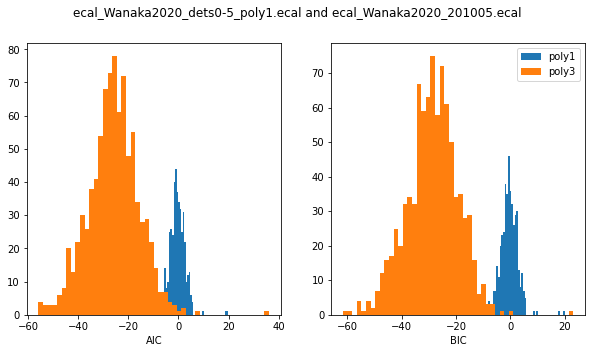

In [943]:
print("poly1: Mean AIC = {}".format(np.mean(AIC_poly1)))
print("poly3: Mean AIC = {}".format(np.mean(AIC_poly3)))
print("poly1: Mean BIC = {}".format(np.mean(BIC_poly1)))
print("poly3: Mean BIC = {}".format(np.mean(BIC_poly3)))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
f.suptitle("{} and {}".format(ecal_poly1,ecal_poly3))

ax1.hist(AIC_poly1,bins=50,label="poly1");
ax1.hist(AIC_poly3,bins=50,label="poly3");
ax1.set_xlabel("AIC")

ax2.hist(BIC_poly1,bins=50,label="poly1");
ax2.hist(BIC_poly3,bins=50,label="poly3");
ax2.set_xlabel("BIC")
ax2.legend(loc="best");

Lower values of AIC and BIC are better. These histograms indicate that poly3 is a better model than poly1. Again, though, I'm not totally confident in these calculations. 

### Look at just detector 0 for a strip-by-strip comparison of AIC, BIC

In [944]:
strips_det0_poly1, AIC_det0_poly1 = allstrips_IC("ecal_Wanaka2020_det0_poly1.ecal",2,criterion="AIC")
strips_det0_poly2, AIC_det0_poly2 = allstrips_IC("ecal_Wanaka2020_det0_poly2.ecal",3,criterion="AIC")
strips_det0_poly3, AIC_det0_poly3 = allstrips_IC("ecal_Wanaka2020_det0.ecal",4,criterion="AIC")
strips_det0_poly4, AIC_det0_poly4 = allstrips_IC("ecal_Wanaka2020_det0_poly4.ecal",5,criterion="AIC")

strips_det0_poly1, BIC_det0_poly1 = allstrips_IC("ecal_Wanaka2020_det0_poly1.ecal",2,criterion="BIC")
strips_det0_poly2, BIC_det0_poly2 = allstrips_IC("ecal_Wanaka2020_det0_poly2.ecal",3,criterion="BIC")
strips_det0_poly3, BIC_det0_poly3 = allstrips_IC("ecal_Wanaka2020_det0.ecal",4,criterion="BIC")
strips_det0_poly4, BIC_det0_poly4 = allstrips_IC("ecal_Wanaka2020_det0_poly4.ecal",5,criterion="BIC")

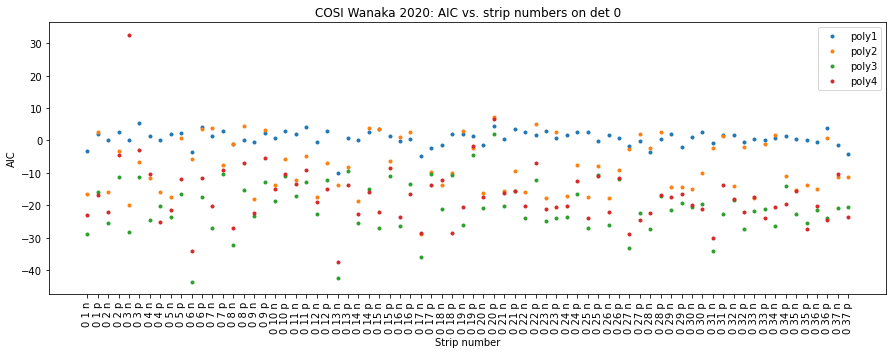

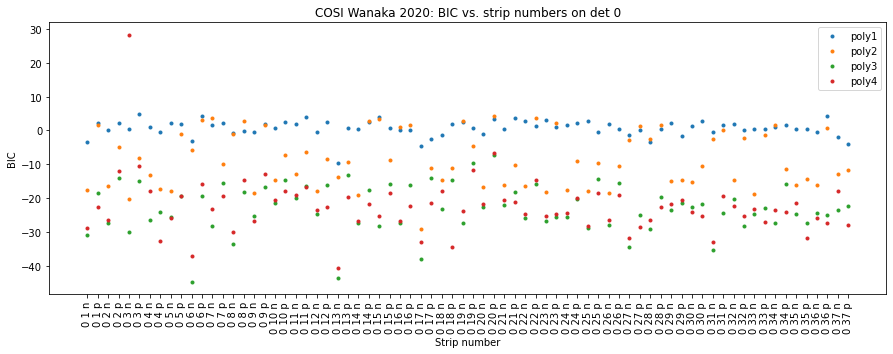

In [945]:
# Plot AIC vs. strip for each calibration 
plt.figure(figsize=(15,5))
plt.plot(strips_det0_poly1,AIC_det0_poly1,'.',label="poly1")
plt.plot(strips_det0_poly2,AIC_det0_poly2,'.',label="poly2")
plt.plot(strips_det0_poly3,AIC_det0_poly3,'.',label="poly3")
plt.plot(strips_det0_poly4,AIC_det0_poly4,'.',label="poly4")
plt.xticks(rotation=90)
plt.xlabel("Strip number");plt.ylabel("AIC")
plt.title("COSI Wanaka 2020: AIC vs. strip numbers on det 0")
plt.legend(loc="best")
plt.show()

# Plot BIC vs. strip for each calibration 
plt.figure(figsize=(15,5))
plt.plot(strips_det0_poly1,BIC_det0_poly1,'.',label="poly1")
plt.plot(strips_det0_poly2,BIC_det0_poly2,'.',label="poly2")
plt.plot(strips_det0_poly3,BIC_det0_poly3,'.',label="poly3")
plt.plot(strips_det0_poly4,BIC_det0_poly4,'.',label="poly4")
plt.xticks(rotation=90)
plt.xlabel("Strip number");plt.ylabel("BIC")
plt.title("COSI Wanaka 2020: BIC vs. strip numbers on det 0")
plt.legend(loc="best");

Again, the poly3 fit appears to outperform the lower order poly1 and poly2 fits.

### Try AIC, BIC on the ASIC

#### Note: There aren't enough calibration points to calculate an AIC on poly3. Does this necessarily imply we should use poly1, since we don't even have enough points to determine whether or not higher order fits are statistically sound? Or, obtain an energy calibration of the ASIC with more calibration lines. 

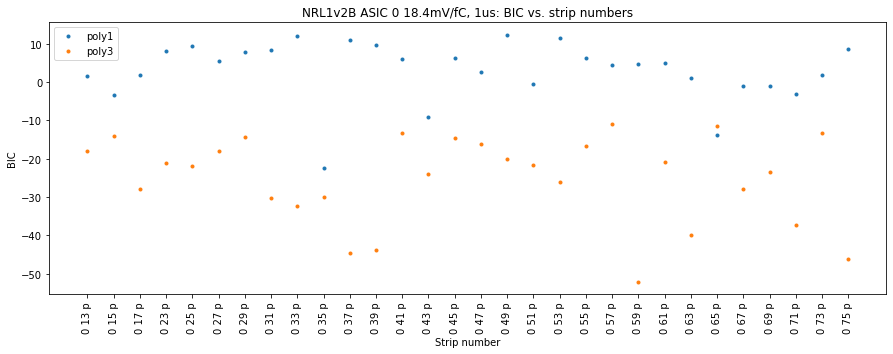

In [946]:
strips_asic_poly1, AIC_asic_poly1 = allstrips_IC("am_bar_cs_1us_18.4mVfC_201009_NRL1v2B_ASIC0_poly1.ecal",2,criterion="AIC")
#strips_asic_poly3, AIC_asic_poly3 = allstrips_IC("am_bar_cs_1us_18.4mVfC_200923_NRL1v2B_ASIC0_poly3.ecal",4,criterion="AIC")

strips_asic_poly1, BIC_asic_poly1 = allstrips_IC("am_bar_cs_1us_18.4mVfC_201009_NRL1v2B_ASIC0_poly1.ecal",2,criterion="BIC")
strips_asic_poly3, BIC_asic_poly3 = allstrips_IC("am_bar_cs_1us_18.4mVfC_200923_NRL1v2B_ASIC0_poly3.ecal",4,criterion="BIC")

# Plot BIC vs. strip for each calibration 
plt.figure(figsize=(15,5))
plt.plot(strips_asic_poly1, BIC_asic_poly1,'.',label="poly1")
plt.plot(strips_asic_poly3, BIC_asic_poly3,'.',label="poly3")
plt.xticks(rotation=90)
plt.xlabel("Strip number");plt.ylabel("BIC")
plt.title("NRL1v2B ASIC 0 18.4mV/fC, 1us: BIC vs. strip numbers")
plt.legend(loc="best");

Per the BIC, poly3 looks better than poly1. However, I'm skeptical of this given the small number of calibration points. 